# Two-Moons Classification

In [1]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../.")
from datasets import classif2d, reg1d
from networks import DenseNet
from utils import SaveModel, entropy
from methods import MCDropout, BNN, MaxWEnt, MaxWEntSVD

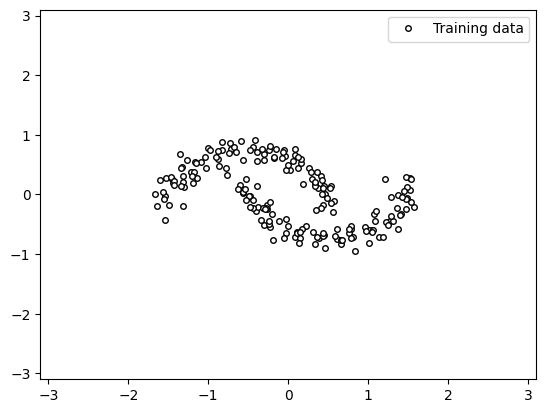

In [2]:
seed = 123
batch_size = 32
epochs = 500
steps_per_epoch = 100

x, y, xval, yval, _, _, xood, yood = classif2d(0)

train_ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x),
                                    tf.data.Dataset.from_tensor_slices(y)))
val_ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(xval),
                              tf.data.Dataset.from_tensor_slices(yval)))
repeat_train = int(epochs * steps_per_epoch * batch_size / x.shape[0]) + 1

train_ds = train_ds.repeat(repeat_train).shuffle(10000).batch(batch_size)
val_ds = val_ds.batch(batch_size)


def show(model=None):
    if model is not None:

        yp = model(xood).numpy()
        
        uncertainties = entropy(yp)
    
        plt.figure(figsize=(5, 4))
        plt.scatter(xood[:, 0], xood[:, 1], c=uncertainties, cmap="Blues")
        
    plt.plot(x[:, 0], x[:, 1], 'o', c="w", markeredgecolor="k",
             markersize=4, label="Training data")
    plt.xlim(xood[:, 0].min(), xood[:, 0].max())
    plt.ylim(xood[:, 1].min(), xood[:, 1].max())
    plt.legend(); plt.show()

show()

### Probabilistic Network

In [3]:
np.random.seed(seed); tf.random.set_seed(seed)
vanilla = DenseNet(input_shape=(2,), last_units=1)
vanilla.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["acc"])
vanilla.fit(train_ds, epochs=100, steps_per_epoch=100, verbose=0,
            callbacks=SaveModel(validation_data=val_ds, monitor="acc", verbose=0));

Restore Weights : Epoch 99  Val loss 1.000


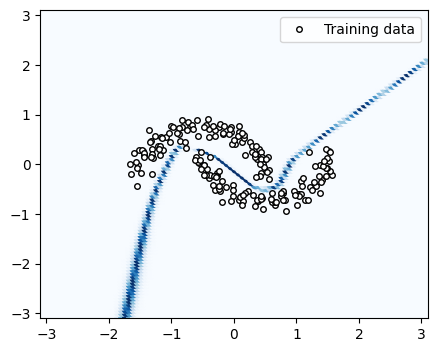

In [4]:
show(vanilla)

### MC-Dropout

In [5]:
np.random.seed(seed); tf.random.set_seed(seed)
base_net = DenseNet(input_shape=(2,), last_units=1)
mcdropout = MCDropout(base_net, rate=0.05)
mcdropout.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["acc"])
mcdropout.fit(train_ds, epochs=500, steps_per_epoch=100, verbose=0,
              callbacks=SaveModel(validation_data=val_ds, monitor="acc", verbose=0));

Restore Weights : Epoch 499  Val loss 1.000


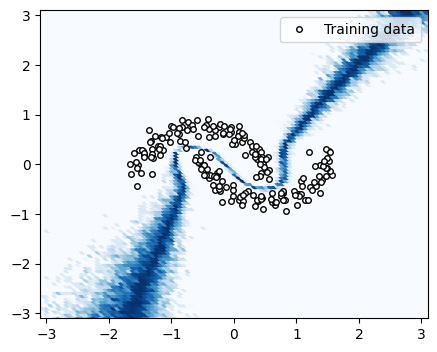

In [6]:
show(mcdropout)

### BNN

In [7]:
np.random.seed(seed); tf.random.set_seed(seed)
base_net = DenseNet(input_shape=(2,), last_units=1)
bnn = BNN(base_net, lambda_=0.001, num_data=x.shape[0])
bnn.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["acc"])
bnn.fit(train_ds, epochs=500, steps_per_epoch=100, verbose=0,
        callbacks=SaveModel(validation_data=val_ds, monitor="acc", verbose=0));

C:\Users\antoi\Anaconda3\envs\statmath11\Lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\antoi\Anaconda3\envs\statmath11\Lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Restore Weights : Epoch 499  Val loss 1.000


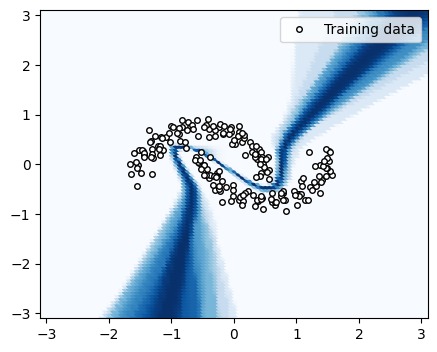

In [8]:
show(bnn)

### MaxWEnt

In [9]:
np.random.seed(seed); tf.random.set_seed(seed)
base_net = DenseNet(input_shape=(2,), last_units=1)
base_net.set_weights(vanilla.get_weights())
maxwent = MaxWEnt(base_net, lambda_=10.)
maxwent.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["acc"])
maxwent.fit(train_ds, epochs=500, steps_per_epoch=100, verbose=0,
            callbacks=SaveModel(threshold=True, validation_data=val_ds, monitor="acc", verbose=0));

Start Training, threshold: 1.000
Restore Weights : Epoch 302  Val loss 1.000


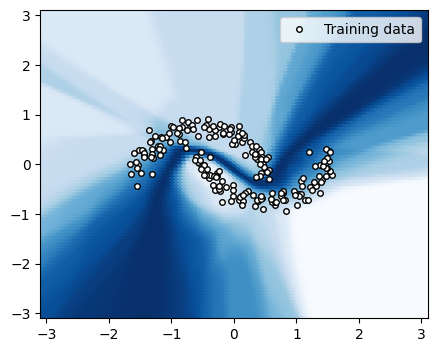

In [10]:
show(maxwent)

### MaxWEnt-SVD

In [11]:
np.random.seed(seed); tf.random.set_seed(seed)
base_net = DenseNet(input_shape=(2,), last_units=1)
base_net.set_weights(vanilla.get_weights())
maxwent_svd = MaxWEntSVD(base_net, lambda_=10.,
                         kernel_noise_initializer=-5.,
                         bias_noise_initializer=-5.,
                         X_train=tf.data.Dataset.from_tensor_slices(x).batch(32))
maxwent_svd.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["acc"])
maxwent_svd.fit(train_ds, epochs=500, steps_per_epoch=100, verbose=0,
            callbacks=SaveModel(threshold=True, validation_data=val_ds, monitor="acc", verbose=0));

Compute SVD
Done! (2, 2)
Compute SVD
Done! (100, 100)
Compute SVD


C:\Users\antoi\Documents\PHD2\Code\jmlr\notebooks\../.\methods\maxent.py:335: ComplexWarning: Casting complex values to real discards the imaginary part
  Vl = Vl.astype(np.float32)


Done! (100, 100)
Compute SVD
Done! (100, 100)
Start Training, threshold: 1.000
Restore Weights : Epoch 490  Val loss 1.000


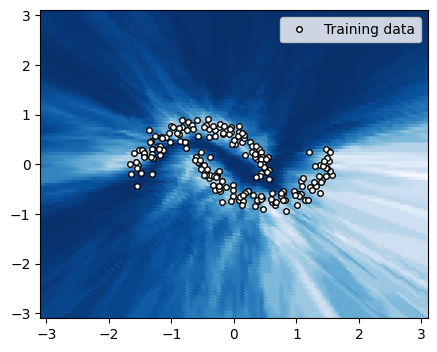

In [12]:
show(maxwent_svd)